In [41]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics  import accuracy_score
import warnings
warnings.simplefilter('ignore')

In [42]:
df=pd.read_csv('train.csv')
df

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10
...,...,...,...,...
912995,2017-12-27,10,50,63
912996,2017-12-28,10,50,59
912997,2017-12-29,10,50,74
912998,2017-12-30,10,50,62


### Business problem statement

### Feature Engineering

In [43]:
# Parse date
df["date"] = pd.to_datetime(df["date"])

In [44]:
#sort for time series
df = df.sort_values(["store", "item", "date"]).reset_index(drop=True)

In [45]:
def generate_features(data):
    df = data.copy()

    # -----------------------------
    # 1. Lag features (memory)
    # -----------------------------
    lag_days = [1, 7, 14, 28]
    for lag in lag_days:
        df[f"lag_{lag}"] = (
            df.groupby(["store", "item"])["sales"]
              .shift(lag)
        )

    # -----------------------------
    # 2. Rolling statistics (trend)
    # -----------------------------
    windows = [7, 14, 28]
    for window in windows:
        df[f"rolling_mean_{window}"] = (
            df.groupby(["store", "item"])["sales"]
              .shift(1)                  # prevent leakage
              .rolling(window)
              .mean()
        )

        df[f"rolling_std_{window}"] = (
            df.groupby(["store", "item"])["sales"]
              .shift(1)
              .rolling(window)
              .std()
        )

    # -----------------------------
    # 3. Demand momentum (LOG-SCALE, FIXED)
    # -----------------------------
    df["growth_1_7"] = np.log1p(df["lag_1"]) - np.log1p(df["lag_7"])
    df["growth_7_14"] = np.log1p(df["lag_7"]) - np.log1p(df["lag_14"])

    # -----------------------------
    # 4. Calendar features (seasonality)
    # -----------------------------
    df["day_of_week"] = df["date"].dt.dayofweek
    df["week_of_year"] = df["date"].dt.isocalendar().week.astype(int)
    df["month"] = df["date"].dt.month
    df["is_weekend"] = df["day_of_week"].isin([5, 6]).astype(int)

    # -----------------------------
    # 5. Treat IDs as categorical
    # -----------------------------
    df["store"] = df["store"].astype("category")
    df["item"] = df["item"].astype("category")

    return df


In [46]:
data = generate_features(df)

In [47]:
# Drop rows with NaNs created by lag/rolling
data = data.dropna().reset_index(drop=True)

In [48]:
print(data.head())

        date store item  sales  lag_1  lag_7  lag_14  lag_28  rolling_mean_7  \
0 2013-01-29     1    1      6   11.0    7.0     5.0    13.0       10.428571   
1 2013-01-30     1    1      9    6.0    9.0     7.0    11.0       10.285714   
2 2013-01-31     1    1     13    9.0    8.0    16.0    14.0       10.285714   
3 2013-02-01     1    1     11   13.0   14.0     7.0    13.0       11.000000   
4 2013-02-02     1    1     21   11.0   12.0    18.0    10.0       10.571429   

   rolling_std_7  rolling_mean_14  rolling_std_14  rolling_mean_28  \
0       2.507133        10.642857        3.973124        10.714286   
1       2.751623        10.714286        3.871564        10.464286   
2       2.751623        10.857143        3.759238        10.392857   
3       2.708013        10.642857        3.521519        10.357143   
4       2.370453        10.928571        3.361874        10.285714   

   rolling_std_28  growth_1_7  growth_7_14  day_of_week  week_of_year  month  \
0        3.077483 

In [49]:
print(data.shape)

(899000, 20)


In [50]:
data.isnull().sum()

date               0
store              0
item               0
sales              0
lag_1              0
lag_7              0
lag_14             0
lag_28             0
rolling_mean_7     0
rolling_std_7      0
rolling_mean_14    0
rolling_std_14     0
rolling_mean_28    0
rolling_std_28     0
growth_1_7         0
growth_7_14        0
day_of_week        0
week_of_year       0
month              0
is_weekend         0
dtype: int64

In [51]:
data["sales"].describe()

count    899000.000000
mean         52.604502
std          28.820886
min           0.000000
25%          30.000000
50%          47.000000
75%          70.000000
max         231.000000
Name: sales, dtype: float64

### Total sales over time (macro trend)

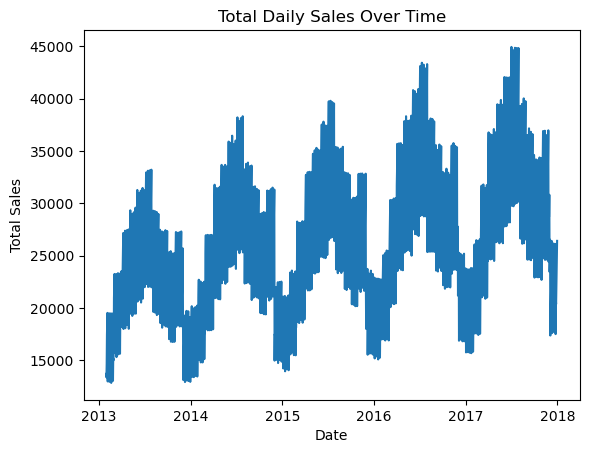

In [52]:
import matplotlib.pyplot as plt

daily_sales = (
    data
    .groupby("date")["sales"]
    .sum()
    .reset_index()
)

plt.figure()
plt.plot(daily_sales["date"], daily_sales["sales"])
plt.xlabel("Date")
plt.ylabel("Total Sales")
plt.title("Total Daily Sales Over Time")
plt.show()


### Distribution of sales (shape matters)

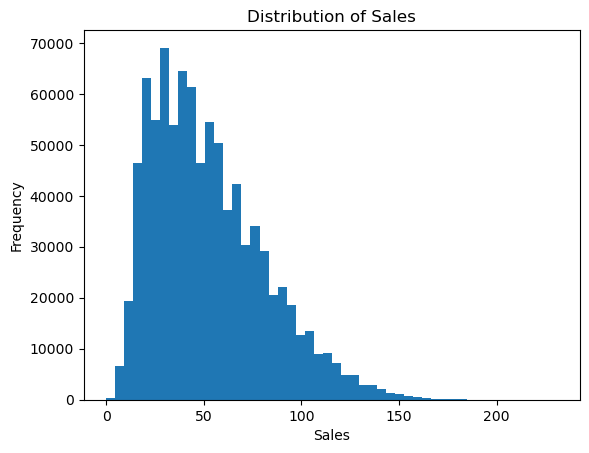

In [53]:
plt.figure()
plt.hist(data["sales"], bins=50)
plt.xlabel("Sales")
plt.ylabel("Frequency")
plt.title("Distribution of Sales")
plt.show()


In [54]:
data[["lag_1", "lag_7", "rolling_mean_7", "growth_1_7"]].describe()

,lag_1,lag_7,rolling_mean_7,growth_1_7
count,899000.000000,899000.000000,899000.000000,899000.000000
mean,52.588293,52.546633,52.566035,0.001108
std,28.823973,28.833553,27.012679,0.287943
min,0.000000,0.000000,5.571429,-2.639057
25%,30.000000,30.000000,30.714286,-0.182322
50%,47.000000,47.000000,48.142857,-0.022473
75%,70.000000,70.000000,69.714286,0.162519
max,231.000000,231.000000,175.428571,2.079442


In [55]:
TARGET = "sales"

FEATURES = [col for col in data.columns 
            if col not in ["date", "sales"]]


In [56]:
TARGET

'sales'

In [57]:
FEATURES

['store',
 'item',
 'lag_1',
 'lag_7',
 'lag_14',
 'lag_28',
 'rolling_mean_7',
 'rolling_std_7',
 'rolling_mean_14',
 'rolling_std_14',
 'rolling_mean_28',
 'rolling_std_28',
 'growth_1_7',
 'growth_7_14',
 'day_of_week',
 'week_of_year',
 'month',
 'is_weekend']

In [58]:
train_df = data[data["date"] < "2017-01-01"]
test_df  = data[data["date"] >= "2017-01-01"]

X_train = train_df[FEATURES]
y_train = train_df[TARGET]

X_test = test_df[FEATURES]
y_test = test_df[TARGET]



In [59]:
print(train_df.shape, test_df.shape)

(716500, 20) (182500, 20)


In [60]:
from sklearn.metrics import mean_absolute_error

baseline_preds = test_df["lag_1"]

baseline_mae = mean_absolute_error(y_test, baseline_preds)
print(f"Baseline MAE: {baseline_mae:.4f}")


Baseline MAE: 11.2447


In [61]:
print("Mean actual sales :", y_test.mean())
print("Mean baseline pred:", baseline_preds.mean())


Mean actual sales : 58.81501369863014
Mean baseline pred: 58.80061369863014


### Model Training

### Logistic Regression

In [64]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [65]:
# Train model
lr = LinearRegression()
lr.fit(X_train, y_train)
# Predictions
y_pred_train = lr.predict(X_train)
y_pred_test = lr.predict(X_test)
# Metrics
train_mae = mean_absolute_error(y_train, y_pred_train)
test_mae = mean_absolute_error(y_test, y_pred_test)
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2 = r2_score(y_test, y_pred_test)

print("TRAIN METRICS")
print(f"MAE  : {train_mae:.4f}")
print(f"RMSE : {train_rmse:.4f}")
print("\nTEST METRICS")
print(f"MAE  : {test_mae:.4f}")
print(f"RMSE : {test_rmse:.4f}")
print(f"\nR2 Score: {r2:.4f}")


TRAIN METRICS
MAE  : 6.3321
RMSE : 8.2488

TEST METRICS
MAE  : 6.8818
RMSE : 8.9966

R2 Score: 0.9187


### Random Forest

In [66]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=12,        # prevents overfitting
    min_samples_leaf=10, # stabilizes predictions
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

# Predictions
rf_train_pred = rf.predict(X_train)
rf_test_pred = rf.predict(X_test)

# Metrics
rf_train_mae = mean_absolute_error(y_train, rf_train_pred)
rf_test_mae = mean_absolute_error(y_test, rf_test_pred)
rf_test_rmse = np.sqrt(mean_squared_error(y_test, rf_test_pred))
rf_r2 = r2_score(y_test, rf_test_pred)

print("RANDOM FOREST RESULTS")
print(f"Train MAE : {rf_train_mae:.4f}")
print(f"Test  MAE : {rf_test_mae:.4f}")
print(f"Test RMSE: {rf_test_rmse:.4f}")
print(f"R2 Score : {rf_r2:.4f}")


RANDOM FOREST RESULTS
Train MAE : 5.6968
Test  MAE : 6.4067
Test RMSE: 8.3722
R2 Score : 0.9296


### Gradient Boosting

In [67]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=5,
    random_state=42
)

gbr.fit(X_train, y_train)

# Predictions
gbr_train_pred = gbr.predict(X_train)
gbr_test_pred = gbr.predict(X_test)

# Metrics
gbr_train_mae = mean_absolute_error(y_train, gbr_train_pred)
gbr_test_mae = mean_absolute_error(y_test, gbr_test_pred)
gbr_test_rmse = np.sqrt(mean_squared_error(y_test, gbr_test_pred))
gbr_r2 = r2_score(y_test, gbr_test_pred)

print("GRADIENT BOOSTING RESULTS")
print(f"Train MAE : {gbr_train_mae:.4f}")
print(f"Test  MAE : {gbr_test_mae:.4f}")
print(f"Test RMSE: {gbr_test_rmse:.4f}")
print(f"R2 Score : {gbr_r2:.4f}")


GRADIENT BOOSTING RESULTS
Train MAE : 5.7310
Test  MAE : 6.2239
Test RMSE: 8.0975
R2 Score : 0.9341


In [73]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

xgb = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1
)

X_train_xgb = X_train.copy()
X_test_xgb  = X_test.copy()

for col in ["store", "item"]:
    X_train_xgb[col] = X_train_xgb[col].cat.codes
    X_test_xgb[col]  = X_test_xgb[col].cat.codes


xgb.fit(X_train_xgb, y_train)

xgb_train_pred = xgb.predict(X_train_xgb)
xgb_test_pred  = xgb.predict(X_test_xgb)


# Metrics
xgb_train_mae = mean_absolute_error(y_train, xgb_train_pred)
xgb_test_mae = mean_absolute_error(y_test, xgb_test_pred)
xgb_test_rmse = np.sqrt(mean_squared_error(y_test, xgb_test_pred))
xgb_r2 = r2_score(y_test, xgb_test_pred)

print("XGBOOST RESULTS")
print(f"Train MAE : {xgb_train_mae:.4f}")
print(f"Test  MAE : {xgb_test_mae:.4f}")
print(f"Test RMSE: {xgb_test_rmse:.4f}")
print(f"R2 Score : {xgb_r2:.4f}")


XGBOOST RESULTS
Train MAE : 5.6434
Test  MAE : 6.1535
Test RMSE: 7.9966
R2 Score : 0.9358


In [75]:
results = pd.DataFrame({
    "Model": [
        "Baseline (Lag-1)",
        "Linear Regression",
        "Random Forest",
        "Gradient Boosting",
        "XGBoost"
    ],
    "Test_MAE": [
        baseline_mae,
        test_mae,
        rf_test_mae,
        gbr_test_mae,
        xgb_test_mae
    ],
    "Test_RMSE": [
        None,
        test_rmse,
        rf_test_rmse,
        gbr_test_rmse,
        xgb_test_rmse
    ],
    "R2_Score": [
        None,
        r2,
        rf_r2,
        gbr_r2,
        xgb_r2
    ]
})

results.sort_values("Test_MAE")


,Model,Test_MAE,Test_RMSE,R2_Score
4,XGBoost,6.153496,7.996603,0.935770
3,Gradient Boosting,6.223920,8.097457,0.934139
2,Random Forest,6.406720,8.372172,0.929595
1,Linear Regression,6.881819,8.996577,0.918701
0,Baseline (Lag-1),11.244734,NaN,NaN


In [96]:
import joblib

joblib.dump(xgb, "xgb_model.pkl")
joblib.dump(FEATURES, "features.pkl")
joblib.dump(data, "processed_data.pkl")


['processed_data.pkl']

### Feature Importance plot

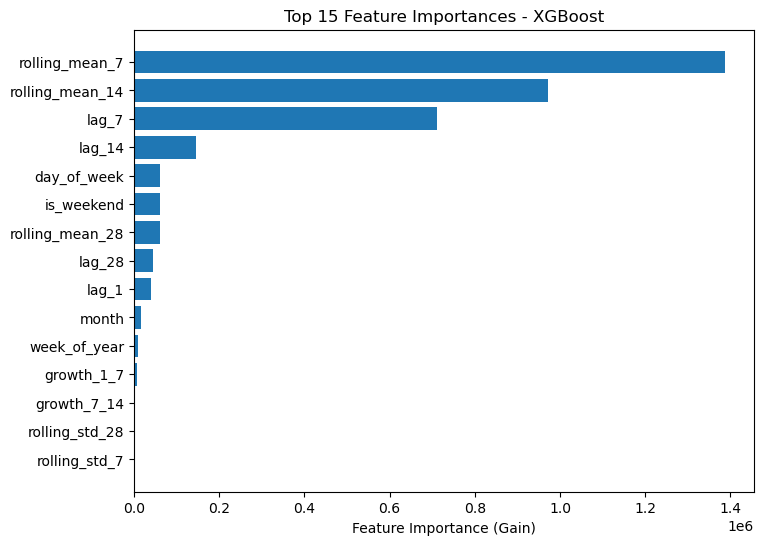

In [76]:
# Get feature importance from XGBoost
importance = xgb.get_booster().get_score(importance_type="gain")

# Convert to DataFrame
fi_df = (
    pd.DataFrame({
        "feature": importance.keys(),
        "importance": importance.values()
    })
    .sort_values("importance", ascending=False)
)

# Take top 15 features
top_fi = fi_df.head(15)

# Plot
plt.figure(figsize=(8, 6))
plt.barh(top_fi["feature"], top_fi["importance"])
plt.gca().invert_yaxis()
plt.xlabel("Feature Importance (Gain)")
plt.title("Top 15 Feature Importances - XGBoost")
plt.show()


### Residuals sanity check

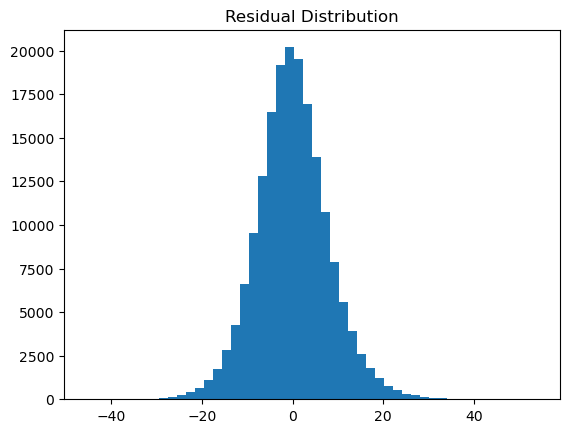

In [77]:
residuals = y_test - xgb_test_pred

plt.figure()
plt.hist(residuals, bins=50)
plt.title("Residual Distribution")
plt.show()


### Time-based prediction check

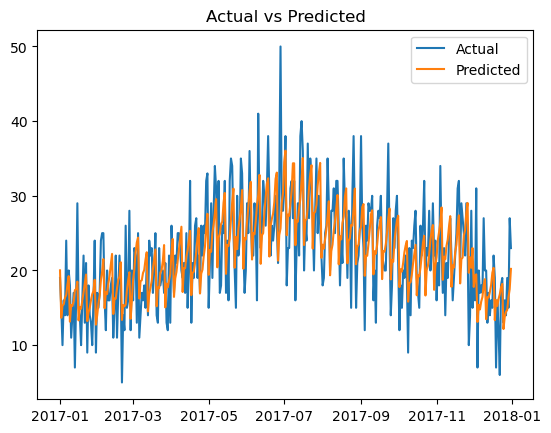

In [78]:
sample = test_df[
    (test_df["store"] == 1) & (test_df["item"] == 1)
]

plt.figure()
plt.plot(sample["date"], sample["sales"], label="Actual")
plt.plot(sample["date"], xgb.predict(sample[FEATURES]), label="Predicted")
plt.legend()
plt.title("Actual vs Predicted")
plt.show()


In [79]:
store_id = 1
item_id = 1

sample = test_df[
    (test_df["store"] == store_id) &
    (test_df["item"] == item_id)
].sort_values("date")


In [80]:
sample["predicted_sales"] = xgb.predict(sample[FEATURES])

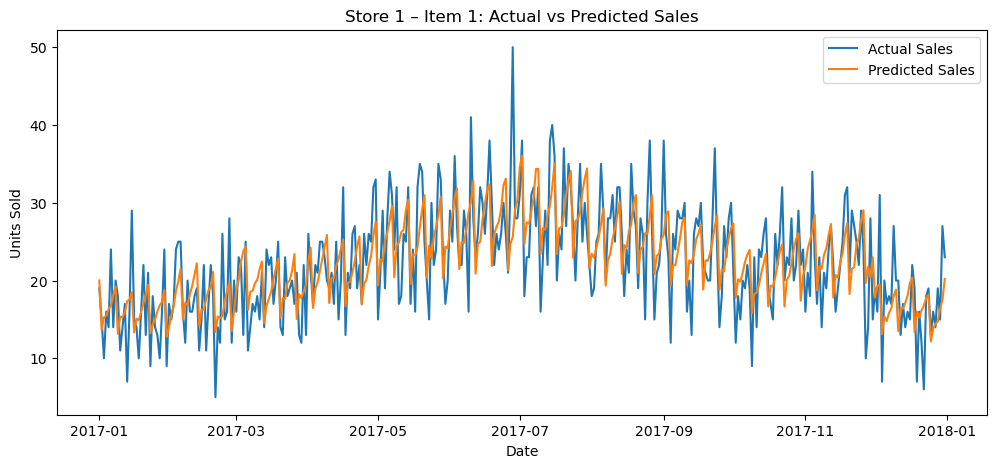

In [81]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(sample["date"], sample["sales"], label="Actual Sales")
plt.plot(sample["date"], sample["predicted_sales"], label="Predicted Sales")
plt.legend()
plt.title(f"Store {store_id} – Item {item_id}: Actual vs Predicted Sales")
plt.xlabel("Date")
plt.ylabel("Units Sold")
plt.show()


In [82]:
sample[["date", "sales", "predicted_sales"]].head(10)


,date,sales,predicted_sales
1433,2017-01-01,19,20.016434
1434,2017-01-02,15,13.659049
1435,2017-01-03,10,15.272416
1436,2017-01-04,16,15.476706
1437,2017-01-05,14,16.345531
1438,2017-01-06,24,16.726627
1439,2017-01-07,14,18.116787
1440,2017-01-08,20,19.243631
1441,2017-01-09,18,13.148280
1442,2017-01-10,11,15.375364


In [83]:
from sklearn.metrics import mean_absolute_error

mae_example = mean_absolute_error(
    sample["sales"],
    sample["predicted_sales"]
)

mae_example


3.957740306854248

In [87]:
latest = data.sort_values("date").iloc[-1]
latest

date               2017-12-31 00:00:00
store                               10
item                                50
sales                               82
lag_1                             62.0
lag_7                             76.0
lag_14                            86.0
lag_28                            75.0
rolling_mean_7               60.857143
rolling_std_7                12.266874
rolling_mean_14              62.714286
rolling_std_14               12.343971
rolling_mean_28              63.928571
rolling_std_28               10.018237
growth_1_7                   -0.200671
growth_7_14                  -0.122103
day_of_week                          6
week_of_year                        52
month                               12
is_weekend                           1
Name: 898999, dtype: object

In [91]:
tomorrow = pd.DataFrame([latest])


In [92]:
tomorrow["date"] = pd.to_datetime(tomorrow["date"]) + pd.Timedelta(days=1)

In [93]:
tomorrow["day_of_week"] = tomorrow["date"].dt.dayofweek.astype(int)
tomorrow["week_of_year"] = tomorrow["date"].dt.isocalendar().week.astype(int)
tomorrow["month"] = tomorrow["date"].dt.month.astype(int)
tomorrow["is_weekend"] = (tomorrow["day_of_week"] >= 5).astype(int)


In [94]:
for col in FEATURES:
    tomorrow[col] = pd.to_numeric(tomorrow[col], errors="raise")


In [95]:
X_tomorrow = tomorrow[FEATURES]
tomorrow_prediction = xgb.predict(X_tomorrow)

tomorrow_prediction


array([53.988716], dtype=float32)